In [ ]:
!pip uninstall -y tensorflow --quiet
!pip install ludwig
!pip install ludwig[llm]

: 

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

: 

In [ ]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
Token:··········


In [ ]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = pd.read_json('/content/formatted_output_new_final.json')

# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value

total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts

split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to make sure that the training examples

np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame

df['split'] = split_values
df['split'] = df['split'].astype(int)


In [ ]:
len(df)

78577

In [ ]:
df.head(10)

,instruction,output,split
0,In the table named head with columns (age INTE...,SELECT COUNT(*) FROM head WHERE age > 56,0
1,In the table named head with columns (name VAR...,"SELECT name, born_state, age FROM head ORDER B...",1
2,In the table named department with columns (cr...,"SELECT creation, name, budget_in_billions FROM...",0
3,In the table named department with columns (bu...,"SELECT MAX(budget_in_billions), MIN(budget_in_...",0
4,In the table named department with columns (nu...,SELECT AVG(num_employees) FROM department WHER...,0
5,In the table named head with columns (name VAR...,SELECT name FROM head WHERE born_state <> 'Cal...,0
6,In the table named department with columns (cr...,SELECT DISTINCT T1.creation FROM department AS...,0
7,In the table named head with columns (born_sta...,SELECT born_state FROM head GROUP BY born_stat...,0
8,In the table named department with columns (cr...,SELECT creation FROM department GROUP BY creat...,0
9,In the table named management with columns (de...,"SELECT T1.name, T1.num_employees FROM departme...",1


Average number of tokens in the instruction column: 51
Average number of tokens in the output column: 25



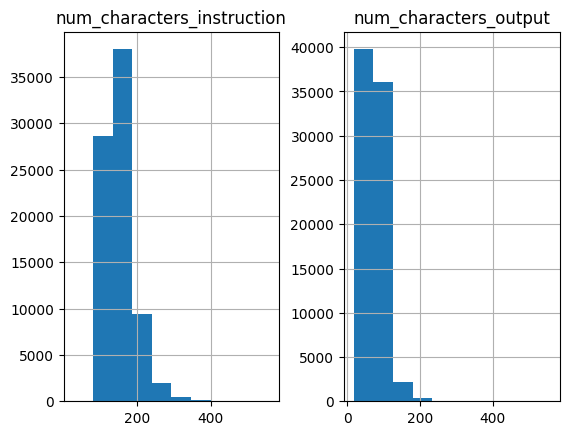

In [ ]:
# Calculating the length of each cell in each column

df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution to display number of characters

df.hist(column=['num_characters_instruction', 'num_characters_output'])

# Calculating the average number of tokens

average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

In [ ]:
#Zero-shot inferencing to get the insight of how the base model works on our dataset before training

zero_shot_config = yaml.safe_load(
  """
  model_type: llm
  base_model: meta-llama/Llama-2-7b-hf

  input_features:
    - name: instruction
      type: text

  output_features:
    - name: output
      type: text

  prompt:
    template: >-
      Below is an instruction that describes a task and the schema of table in the database. Write a response that generates request that is in the form of a SQL query. Here the schema of the table is mentioned first followed by the question for which the query needs to be generated.

      ### Instruction: {instruction}

      ### Response:

  generation:
    temperature: 0.5 # Temperature is used to control the randomness of predictions.
    max_new_tokens: 512

  preprocessing:
    split:
      type: fixed
    tokenize:
      type: word

  quantization:
    bits: 4
  """
)

model = LudwigModel(config=zero_shot_config, logging_level=logging.INFO)
results = model.train(dataset=df[:10])

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'None': 134 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 136 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 136 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'output': 65 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 67 (including start and stop symbols)
INFO:ludwig.features

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.trainers.trainer_llm:
Running evaluation for step: 0, epoch: 0


Evaluation valid:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.5,
  "transformers_version": "4.33.2"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task and the schema of table in the database. write a response that generates request that is in the form of a sql query. here the schema of the table is mentioned first followed by the question for which the query needs to be generated.
### instruction: in the table named head with columns (name varchar, born_state varchar, age varchar), list the name, born state and age of the heads of departments ordered by age.
### response:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset 

Evaluation valid:  50%|█████     | 1/2 [00:50<00:50, 50.85s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.5,
  "transformers_version": "4.33.2"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task and the schema of table in the database. write a response that generates request that is in the form of a sql query. here the schema of the table is mentioned first followed by the question for which the query needs to be generated.
### instruction: in the table named management with columns (department_id varchar, temporary_acting varchar); create table department (name varchar, num_employees varchar, department_id varchar), show the name and number of employees for the departments managed by heads whose temporary acting value is 'yes'?
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task and the schema of ta

Evaluation valid: 100%|██████████| 2/2 [01:37<00:00, 48.61s/it]

INFO:ludwig.trainers.trainer_llm:Evaluation took 1m 37.2648s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤═════════╤══════════════╤════════╕
│                       │ train   │   validation │ test   │
╞═══════════════════════╪═════════╪══════════════╪════════╡
│ bleu                  │         │       0.0131 │        │
├───────────────────────┼─────────┼──────────────┼────────┤
│ char_error_rate       │         │       0.9912 │        │
├───────────────────────┼─────────┼──────────────┼────────┤
│ loss                  │         │      10.3735 │        │
├───────────────────────┼─────────┼──────────────┼────────┤
│ next_token_perplexity │         │   32000.0645 │        │
├───────────────────────┼─────────┼──────────────┼────────┤
│ perplexity            │         │   32000.0039 │        │
├───────────────────────┼─────────┼──────────────┼────────┤
│ rouge1_fmeasure       │         │       0.0725 │        │
├───────────────────────┼─────────┼──────────────┼────────

In [ ]:
#Training the Llama 2 model on our custom SQL dataset

model = None
clear_cache()

qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: meta-llama/Llama-2-7b-hf

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
   Below is an instruction that describes a task and the schema of table in the database. Write a response that generates request that is in the form of a SQL query. Here the schema of the table is mentioned first followed by the question for which the query needs to be generated.

    ### Instruction: {instruction}

    ### Response:

generation:
  temperature: 0.5
  max_new_tokens: 512
  top_p: 0.5

adapter:
  type: lora
  lora_activation: relu
  lora_type: lora_highway

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  tokenize:
      type: word
  stop_words:
    type: none
  lemmatize: True
  split:
    type: fixed
    probabilities:
    - 1
    - 0
    - 0

trainer:
  type: finetune
  train_steps: 20
  epochs: 2
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 8
  learning_rate: 0.0005
  learning_rate_scheduler:
    type: cosine_annealing
  adam_beta1: 0.9
  adam_beta2: 0.99
  epsilon: 1e-8
  warmup_fraction: 0.06
  weight_decay: 1e-5
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_0                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded HuggingFace

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 20 step(s), approximately 0 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 100 step(s), approximately 0 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training: 100%|██████████| 20/20 [00:14<00:00,  1.11it/s, loss=0.135]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 20, epoch: 0


Evaluation test : 100%|██████████| 1965/1965 [50:39<00:00,  1.55s/it]

INFO:ludwig.trainers.trainer:Evaluation took 1h 40m 24.3554s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0641 │       0.0590 │     0.0597 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     0.8289 │       0.8504 │     0.8514 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     1.5815 │       1.6193 │     1.6435 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 15137.8799 │   15701.7891 │ 15793.3525 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31999.6367 │   31533.9199 │ 31560.2734 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │  


Training: 100%|██████████| 20/20 [1:40:39<00:00, 302.00s/it, loss=0.135]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤════════════════════╕
│ Validation feature           │ output             │
├──────────────────────────────┼────────────────────┤
│ Validation metric            │ loss               │
├──────────────────────────────┼────────────────────┤
│ Best model step              │ 20                 │
├──────────────────────────────┼────────────────────┤
│ Best model epoch             │ 1                  │
├──────────────────────────────┼────────────────────┤
│ Best model's validation loss │ 1.6192708015441895 │
├──────────────────────────────┼────────────────────┤
│ Best model's test loss       │ 1.6435189247131348 │
╘══════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig.api:Saved to

In [ ]:
test_examples = pd.DataFrame([
   {
   "instruction": "In the employees table with columns id (integer), first_name (text), last_name (text), age (integer), and department (text), retrieve the first and last names of all employees who are younger than 25."
}
])

predictions = model.predict(test_examples)[0]
print(type(predictions))
keysList = list(predictions.keys())
print(keysList)
for input_with_prediction in zip(test_examples['instruction'], predictions['output_response']):
  print(f"Instruction: {input_with_prediction[0]}")
  print(f"Generated Output: {input_with_prediction[1][0]}")
  print("\n\n")

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/ludwig/data/preprocessing.py:1315: UserWarning: column: 'split' is required by the dataset splitter with params: {'type': 'fixed', 'column': 'split'}, but 'split' is not present in the `dataset_df` with columns: Index(['instruction'], dtype='object'). This is acceptable during serving setting where dataset splitting is irrelevant. You may see this warning if, for example, the model was trained with a configuration that used a stratified split on the target column, but for live predictions, a value for the target column is not to be provided.
  warnings.warn(


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.5,
  "top_p": 0.5,
  "transformers_version": "4.33.2"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task and the schema of table in the database. write a response that generates request that is in the form of a sql query. here the schema of the table is mentioned first followed by the question for which the query needs to be generated.

 ### instruction: in the employees table with columns id (integer), first_name (text), last_name (text), age (integer), and department (text), retrieve the first and last names of all employees who are younger than 25.

 ### response:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based ge

Prediction: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer


<class 'pandas.core.frame.DataFrame'>
['output_predictions', 'output_probabilities', 'output_response', 'output_probability']
Instruction: In the employees table with columns id (integer), first_name (text), last_name (text), age (integer), and department (text), retrieve the first and last names of all employees who are younger than 25.
Generated Output: 

```sql
SELECT first_name, last_name
FROM employees
WHERE age < 25
```







/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))
